In [1]:
from IPython import display
from IPython.core.display import Image

In [2]:
%matplotlib inline
#%matplotlib notebook


%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2024

&nbsp;
&nbsp;
&nbsp;
# Lab 1. Support Vector Machines for Classification

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

In [5]:
def wb_from_ab(a, b):
    if a < 0:
        return np.array([-a, 1]), -b
    return np.array([a, -1]), b

def ab_from_xy(x,y):
    X = np.ones((2,2))
    X[0,0] = x[0]
    X[1,0] = x[1]
    w = np.linalg.solve(X,y)
    return w[0], w[1]

def plot_linear_classifier(xmin, xmax, ymin, ymax,w,ax,b=0, color='black',margin=False):
    # generate a grid of points to evaluate classifier
    npoints = 100
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    zz = X*w[0] + Y*w[1] + b
    ax.contour(X, Y, zz, [0], colors=color)
    if margin:
        ax.contour(X, Y, zz, [-1,1], linestyles='dashed', colors=color)
    return ax.contourf(X, Y, zz, 20, cmap='PuOr', alpha=0.2)
def dame_grid(xc, nn=20):
    xmin = np.min(xc[:, 0])
    xmin -= .05*np.absolute(xmin)
    xmax = np.max(xc[:, 0])
    xmax += .05*np.absolute(xmax)
    ymin = np.min(xc[:, 1])
    ymin -= .05*np.absolute(ymin)
    ymax = np.max(xc[:, 1])
    ymax += .05*np.absolute(ymax)
    Xg = np.linspace(xmin,
                   xmax ,
                   nn) # or whatever values for x
    Yg = np.linspace(ymin,
                   ymax ,
                   nn)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    x_grid = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    return x_grid, Xshape, Xg, Yg

# 1.- Simple binary classification problem

Run the next cell to generate a toy data set. The outcome of the cell that you need for the remainder of the notebook are the following variables:
- `Xtrain`: observations of the training set
- `Xtest`: observations of the test set
- `Ytrain`: true class labels for the observations in the training set
- `Ytest`: true class labels for the observations in the test set. Notice that in a real world situation you will not have access to these labels (if you already know the class of the test observations there is little point in using an automatic classifier to guess them). You will use these labels to evaluate the quality of the classifier.

In [6]:
# generate observations and lables of a classification toy problem

X, Y = datasets.make_blobs(n_samples=200,
                           centers=[(2.5,4),
                                   (-2.5,-4)],
                  random_state=1, cluster_std=1.5)
Y[Y==0]=-1 # set the negative class labels to -1, since we are using SVMs


# split the dataset in training and test sets, in order to evaluate the models generalization capabilities

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=50)


# generate a grid of points for drawing purposes

x_grid, Xshape, Xg, Yg = dame_grid(X, nn=20)



Run the next cell to plot the data set

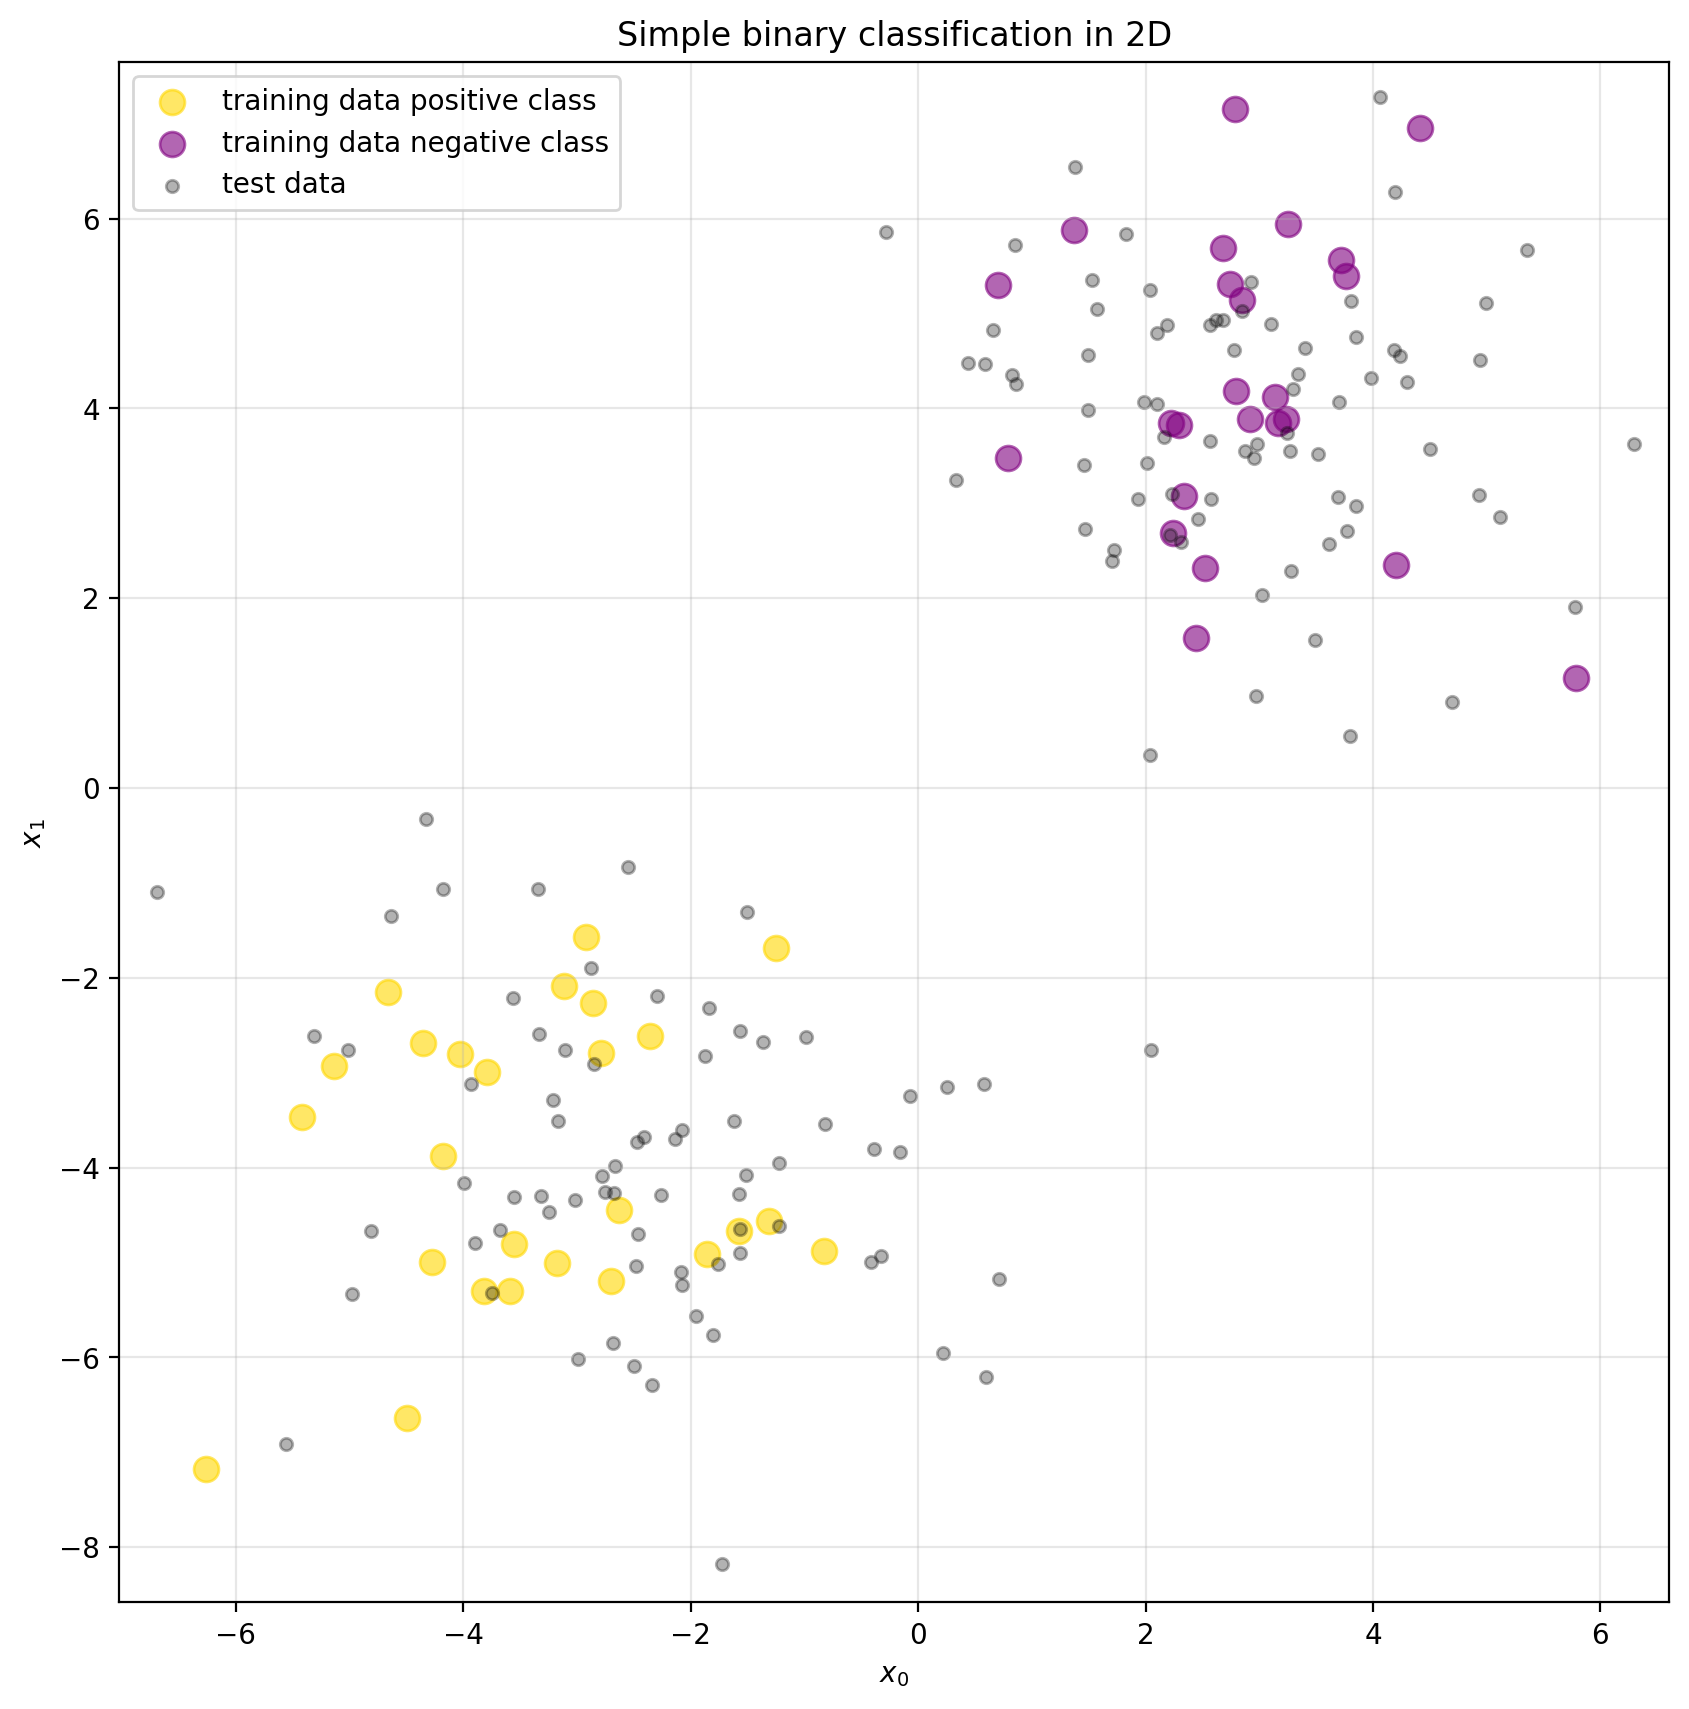

In [7]:
plt.figure(figsize=(10,10))


_=plt.scatter(Xtrain[Ytrain==1, 0],
              Xtrain[Ytrain==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='training data positive class')
_=plt.scatter(Xtrain[Ytrain==-1, 0],
              Xtrain[Ytrain==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='training data negative class')

_=plt.scatter(Xtest[:, 0], Xtest[:, 1], s=20, color='black', alpha=0.3, label='test data')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Simple binary classification in 2D')
plt.axis([np.min(x_grid[:,0]),
          np.max(x_grid[:,0]),
          np.min(x_grid[:,1]),
          np.max(x_grid[:,1])])
_=plt.legend()
_=plt.grid(alpha=0.3)

## 1.1 Solution with linear classifiers that pass through the origin optimized using brute force

The first model we are using to solve the classification problem are **linear classifiers** whose boundaries pass through the origin. This means that the classifier has the expression

$$
f(\mathbf x) = \mbox{sign} \{\mathbf w^\top \mathbf x\}
$$

That is, $b=0$ in the expression we saw in the lecture and the only parameter that we need to define the classifier is the weight vector $\mathbf w$.

We are going to use brute force to find the classifier, this means running an exhaustive search in the space of the linear classifiers that pass through the origin until we find one that classifies the training data without errors. We can reduce the search space (without affecting the quality of the results) by requesting that $\mathbf w$ has unit length, that is $\mathbf w^\top \mathbf w = 1$.

In the next cell write code that implements the following functionality:
- run a loop that explores the search space of weight vectors that define linear classifiers that pass through the origin (hint: define each classifier with the angle of its weight vector)
- in each iteration of the loop:
    - construct the corresponding weight vector
    - use it to classify the training data set
    - compute the number of classification errors in the training set
    - if there are no errors in the training set exit the loop and store the weight vector in a numpy array called 'best_w'

In [8]:
# YOUR CODE
# Initialize best_w and best_error
best_w = np.array([0, 0])
best_margin = 0

# Iterate over angles from 0 to 360 degrees
for i, angle in enumerate(np.linspace(0,2*np.pi,100)):
    # Calculate the weight vector for the current angle
  w = np.array([np.cos(angle), np.sin(angle)])
  margin = np.min(Ytrain * Xtrain.dot(w))
  if margin > best_margin:
    best_margin = margin
    best_w = w
    print(i)
    break
print(best_w)
print(best_margin)

48
[-0.99547192  0.09505604]
0.1945998676358685


Run the next cell to plot the classifier found in the previous one. In red you have the weight vector of the classifier, in black the classification boundary.

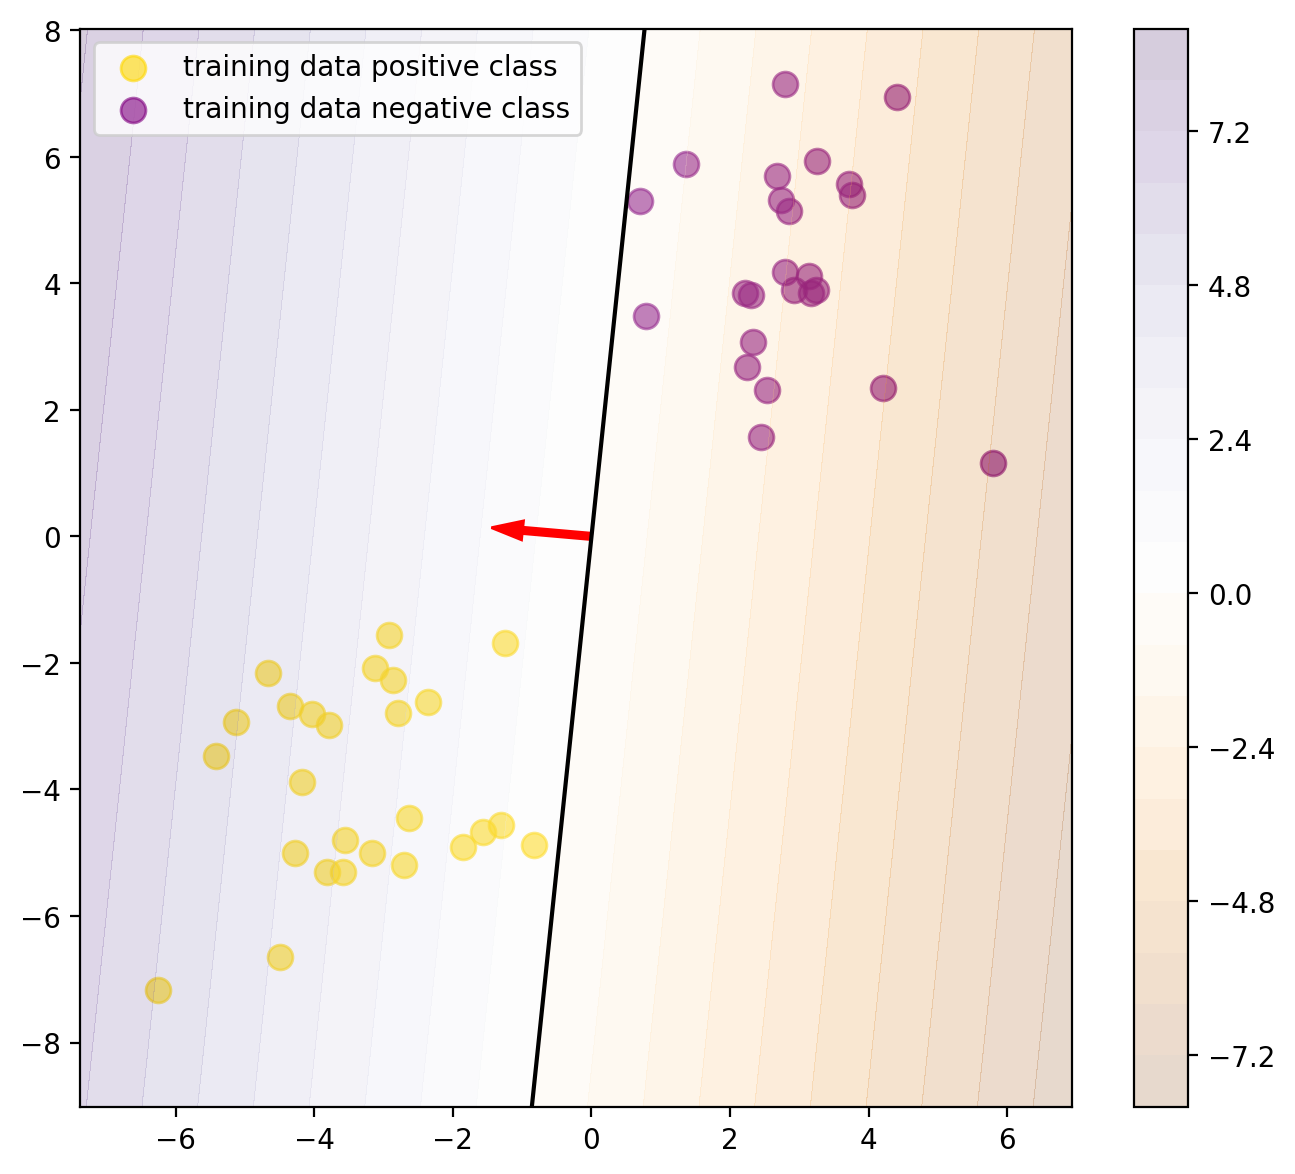

In [9]:
ff,ax = plt.subplots(1,1,figsize=(8,7))
_=ax.scatter(Xtrain[Ytrain==1, 0],
              Xtrain[Ytrain==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='training data positive class')
_=ax.scatter(Xtrain[Ytrain==-1, 0],
              Xtrain[Ytrain==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='training data negative class')
cs = plot_linear_classifier(np.min(x_grid[:,0]),
                                np.max(x_grid[:,0]),
                                np.min(x_grid[:,1]),
                                np.max(x_grid[:,1]),
                                best_w,
                                ax,
                                0.0,
                                'black',
                                margin=False)
ax.arrow(0,0,best_w[0], best_w[1],color='red', shape='full',width=.1)
ax.legend()
_=ff.colorbar(cs, ax=ax)

Now evaluate the quality of this classifier in the test set.

Write code in the next cell that:
- uses `best_w` to predict labels for the test set. Store the predicted labels in a numpy array called `Yp`
- compares these classifications with the true labels
- prints the accuracy of `best_w`

In [10]:
# YOUR CODE
for i, angle in enumerate(np.linspace(0,2*np.pi,100)):
    # Calculate the weight vector for the current angle
  w = np.array([np.cos(angle), np.sin(angle)])
  margin = np.min(Ytrain * Xtrain.dot(w))
  if margin > best_margin:
    best_margin = margin
    best_w = w

print(best_w)
print(best_margin)
Yp = np.sign(Xtest.dot(best_w))
print(np.mean(Yp == Ytest))

[-0.60560969 -0.79576184]
2.095413315173488
1.0


Now run the following cell to plot the classification of the test set.

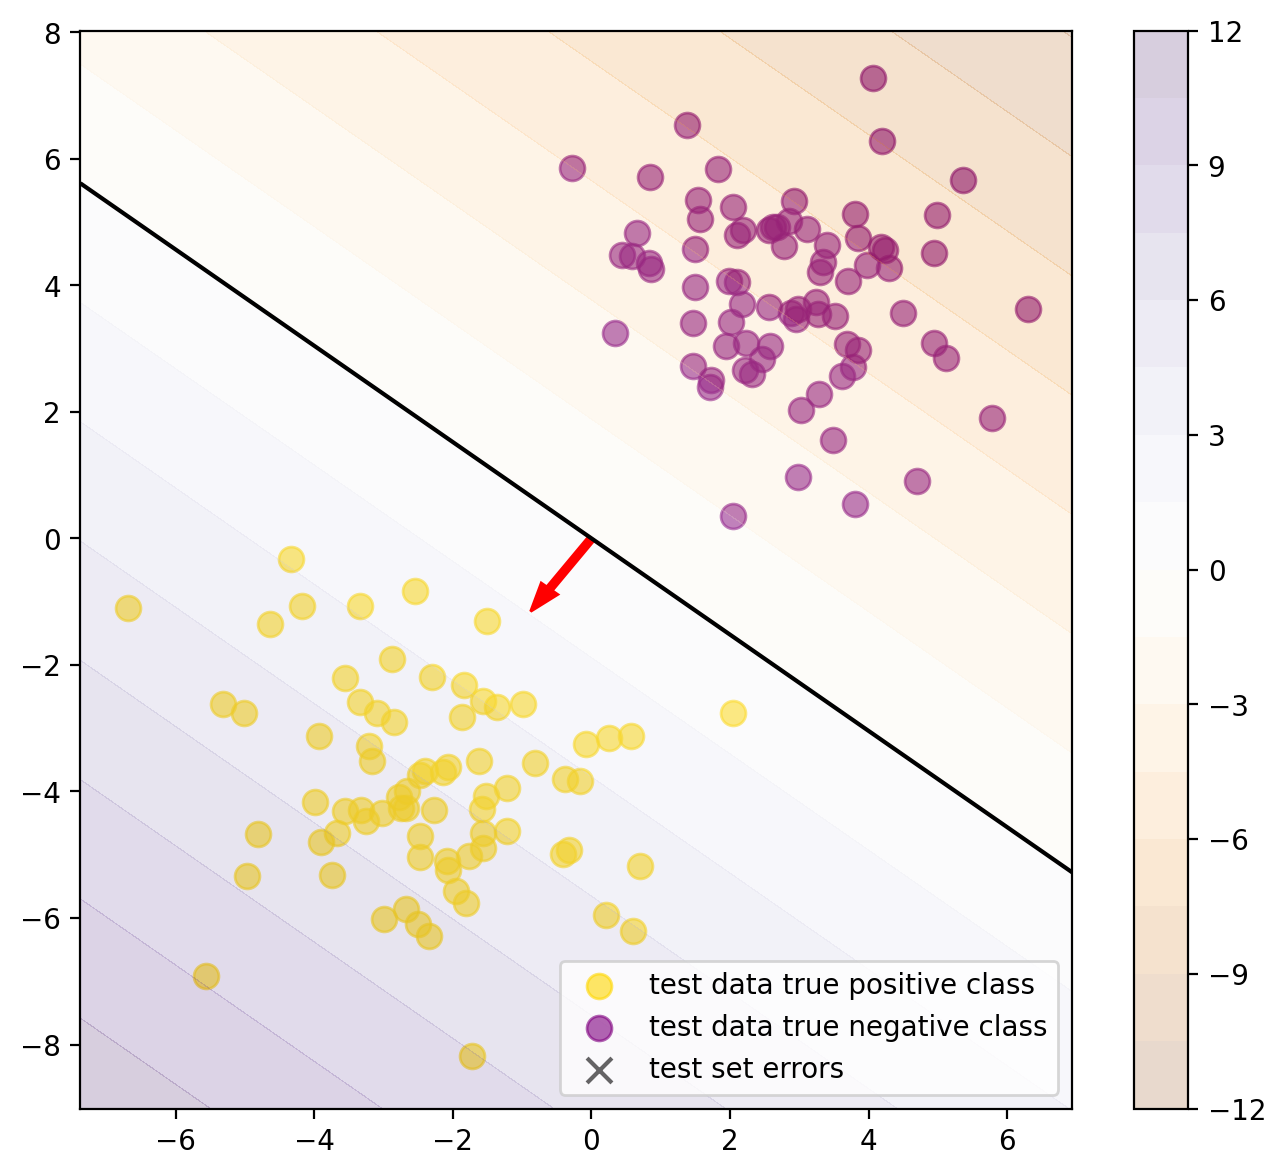

In [11]:
ff,ax = plt.subplots(1,1,figsize=(8,7))
_=ax.scatter(Xtest[Ytest ==1, 0],
              Xtest[Ytest ==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='test data true positive class')
_=ax.scatter(Xtest[Ytest==-1, 0],
              Xtest[Ytest==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='test data true negative class')
cs = plot_linear_classifier(np.min(x_grid[:,0]),
                                np.max(x_grid[:,0]),
                                np.min(x_grid[:,1]),
                                np.max(x_grid[:,1]),
                                best_w,
                                ax,
                                0.0,
                                'black',
                                margin=False)
ax.arrow(0,0,best_w[0], best_w[1],color='red', shape='full',width=.1)

Test_Errors = Yp != Ytest

_=ax.scatter(Xtest[Test_Errors, 0],
              Xtest[Test_Errors, 1],
             marker = 'x',
              c='black',
              s=80,
              alpha=0.6,
              label='test set errors')
ax.legend()
_=ff.colorbar(cs, ax=ax)

## 1.2 Solution with linear classifiers that pass through the origin optimized and maximum margin using brute force

As we saw in the lecture, **maximizing the margin** can lead to good classification performances. So we are improving the classifier of the previous section by adding the margin maximization feature to its design.

For this purpose, copy the cell with the loop that finds the linear classify and include the following modifications:

- run a loop that explores the search space of weight vectors that define linear classifiers that pass through the origin (hint: define each classifier with the angle of its weight vector)
- in each iteration of the loop:
    - construct the corresponding weight vector
    - use it to classify the training data set
    - **compute the functional margin of the observations in the training set**
    - **compare this margin with the maximum margin you have obtained so far. If this margin is better, update the best margin and also the best classifier**
    - return the classifier that gives you the best margin in a np array called 'best_w_max_margin'

In [ ]:
# YOUR CODE



Run the next cell to plot the classifier found in the previous one. In red you have the weight vector of the classifier, in black the classification boundary.

NameError: name 'best_w_max_margin' is not defined

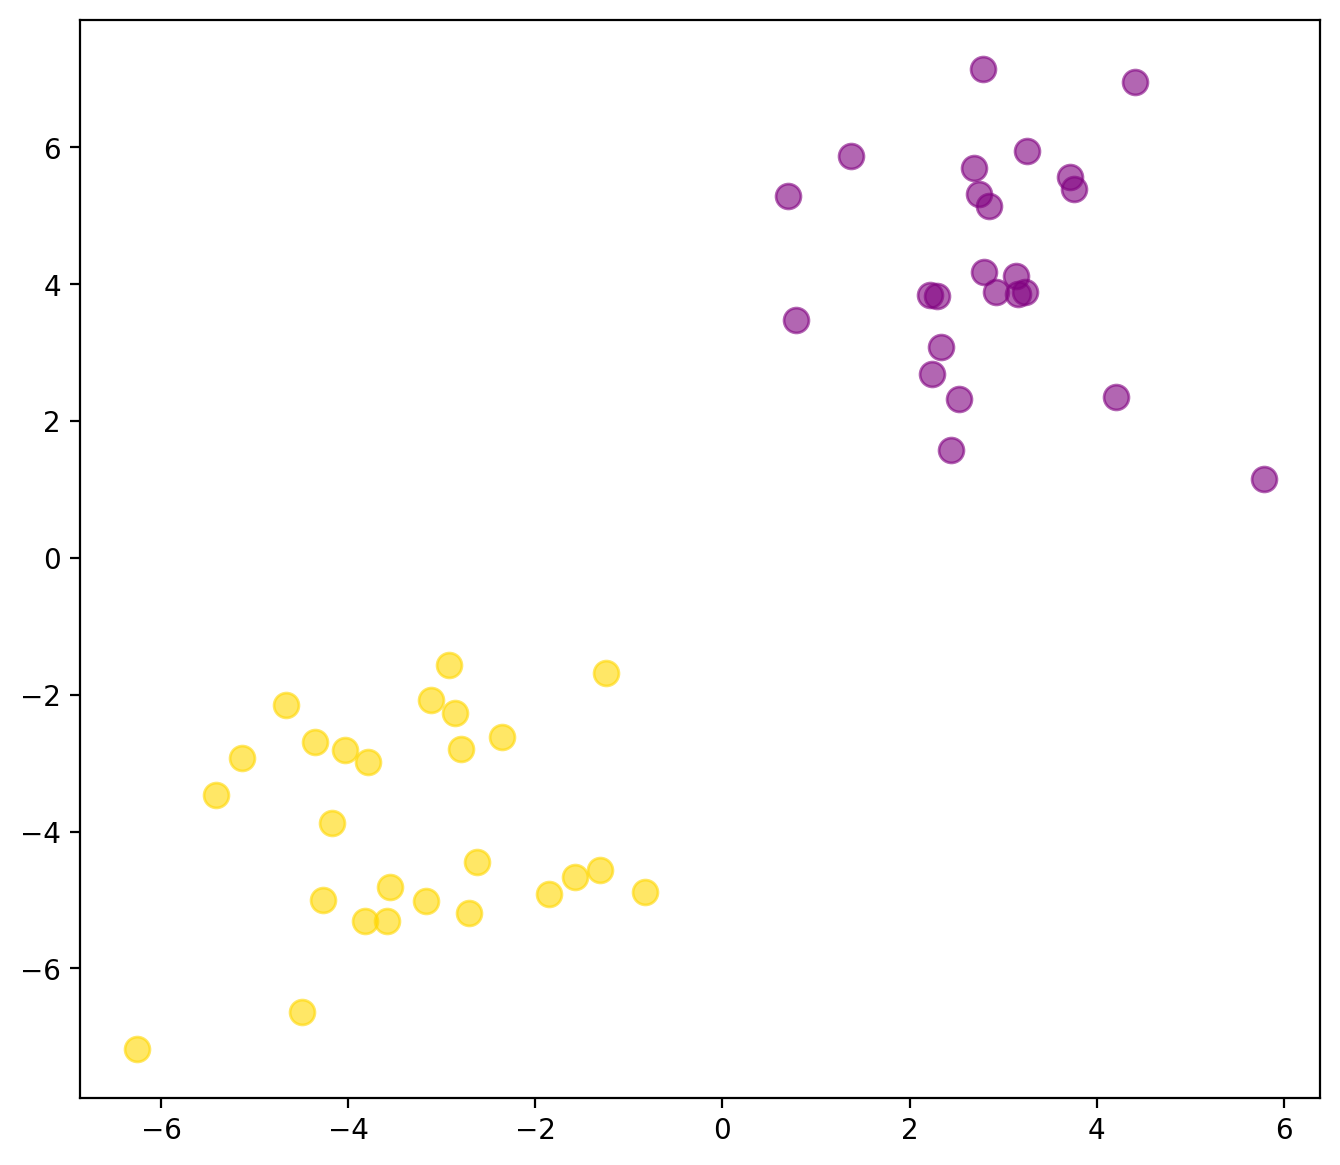

In [12]:
ff,ax = plt.subplots(1,1,figsize=(8,7))
_=ax.scatter(Xtrain[Ytrain==1, 0],
              Xtrain[Ytrain==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='training data positive class')
_=ax.scatter(Xtrain[Ytrain==-1, 0],
              Xtrain[Ytrain==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='training data negative class')
cs = plot_linear_classifier(np.min(x_grid[:,0]),
                                np.max(x_grid[:,0]),
                                np.min(x_grid[:,1]),
                                np.max(x_grid[:,1]),
                                best_w_max_margin,
                                ax,
                                0.0,
                                'black',
                                margin=False)
ax.arrow(0,0,best_w_max_margin[0], best_w_max_margin[1],color='red', shape='full',width=.1)
ax.legend()
_=ff.colorbar(cs, ax=ax)

Now evaluate the quality of this classifier in the test set.

Write code in the next cell that:
- uses `best_w_max_margin` to predict labels for the test set. Store the predicted labels in a numpy array called `Yp_max_margin`
- compares these classifications with the true labels
- prints the accuracy of `best_w_max_margin`


In [ ]:
# YOUR CODE

Now run the following cell to plot the classification of the test set.

NameError: name 'best_w_max_margin' is not defined

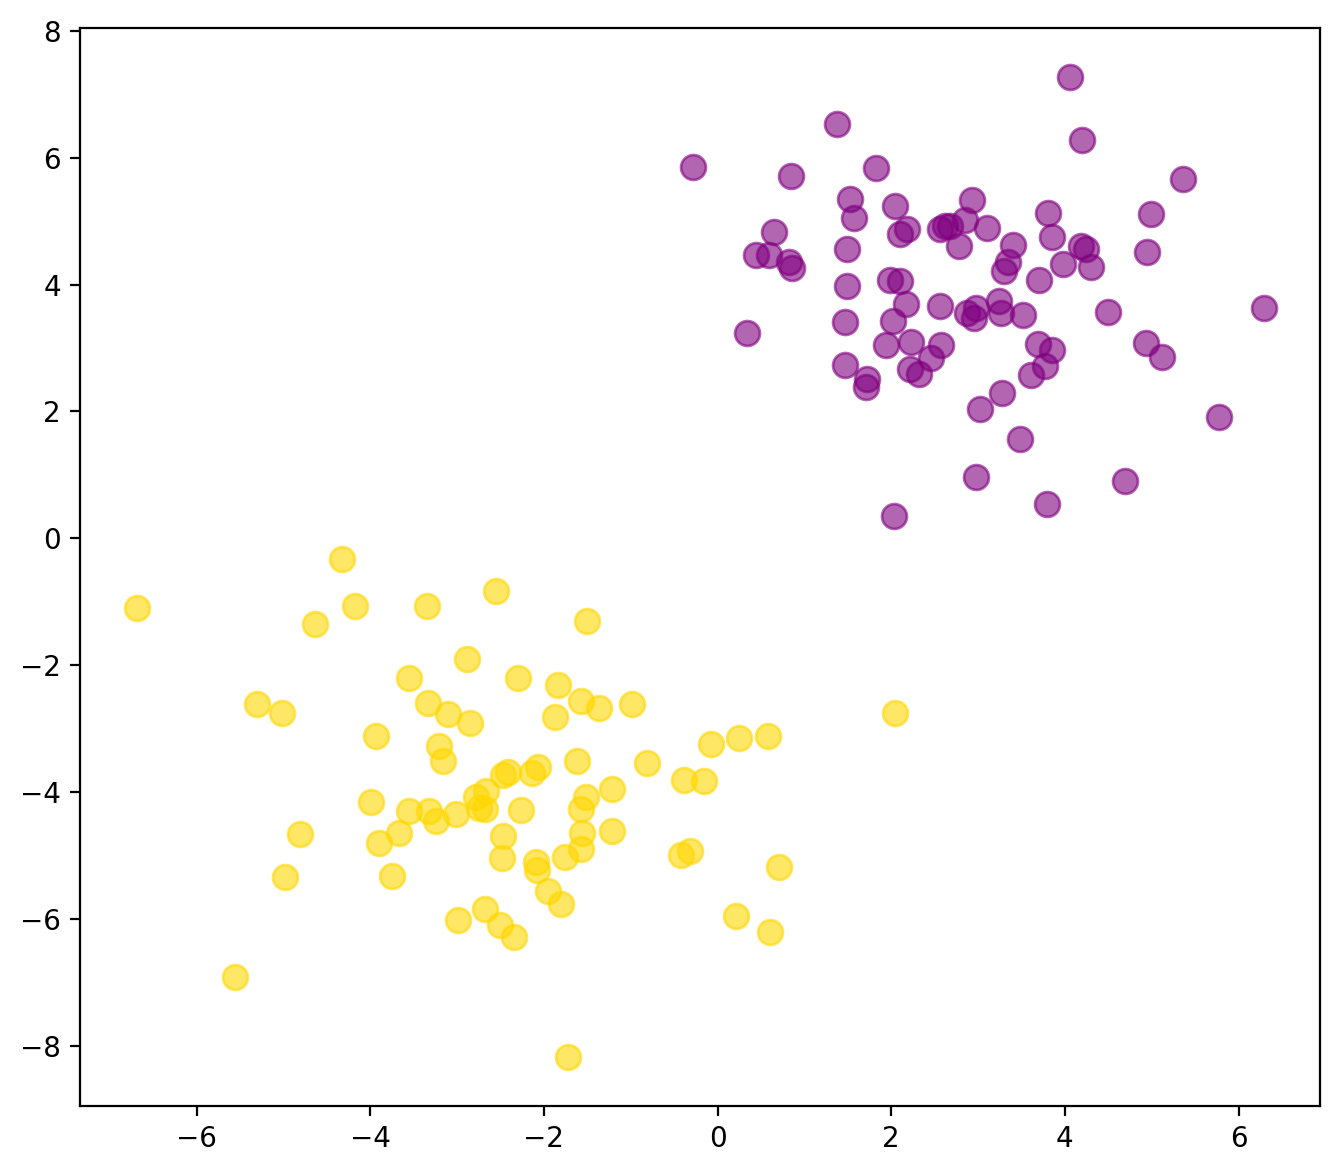

In [13]:
ff,ax = plt.subplots(1,1,figsize=(8,7))
_=ax.scatter(Xtest[Ytest ==1, 0],
              Xtest[Ytest ==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='test data true positive class')
_=ax.scatter(Xtest[Ytest==-1, 0],
              Xtest[Ytest==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='test data true negative class')
cs = plot_linear_classifier(np.min(x_grid[:,0]),
                                np.max(x_grid[:,0]),
                                np.min(x_grid[:,1]),
                                np.max(x_grid[:,1]),
                                best_w_max_margin,
                                ax,
                                0.0,
                                'black',
                                margin=False)
ax.arrow(0,0,best_w_max_margin[0], best_w_max_margin[1],color='red', shape='full',width=.1)

Test_Errors = Yp_max_margin != Ytest

_=ax.scatter(Xtest[Test_Errors, 0],
              Xtest[Test_Errors, 1],
             marker = 'x',
              c='black',
              s=80,
              alpha=0.6,
              label='test set errors')
ax.legend()
_=ff.colorbar(cs, ax=ax)

## 1.3 Linear Support Vector Machine

Now we will find the maximum margin classifier using SVM. Check the [`SVC` class documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) in sklearn in order to find out how to use this implementation.

In [14]:
from sklearn.svm import SVC # don't forget to import the modules!!

In the next cell write code that
- Instantiates an object of the SVC class, called `svc`. With a linear kernel and $C=10^8$
- Fits the classifier with the training set
- Evaluates the classifier performance with the test set (print the accuracy)
- Stores the labels predicted for the test set in a np array called `Yp_svm`

In [16]:
# YOUR CODE %%
svc = SVC(kernel='linear', C=1e8)
svc.fit(Xtrain, Ytrain)
print(svc.score(Xtest, Ytest))
Yp_svm = svc.predict(Xtest)

1.0


Find out where does the `SVC` class stores the weight vector of the classifier and store it in a np array called `w_svm`

In [ ]:
# YOUR CODE
w_svm = svc.coef_[0]
print(w_svm)


[-0.26744803 -0.30787009]


Do the same with scalar $b$ (from the $\mathbf w^\top + b$), storing it in a variable called `b_svm`

In [ ]:
# YOUR CODE
b_svm = svc.intercept_[0]
print(b_svm)

0.1927102997502831


Run the following cell to plot the SVM classifier. Learn about method `decision_function` in the sklearn documentation of the `SVC`.

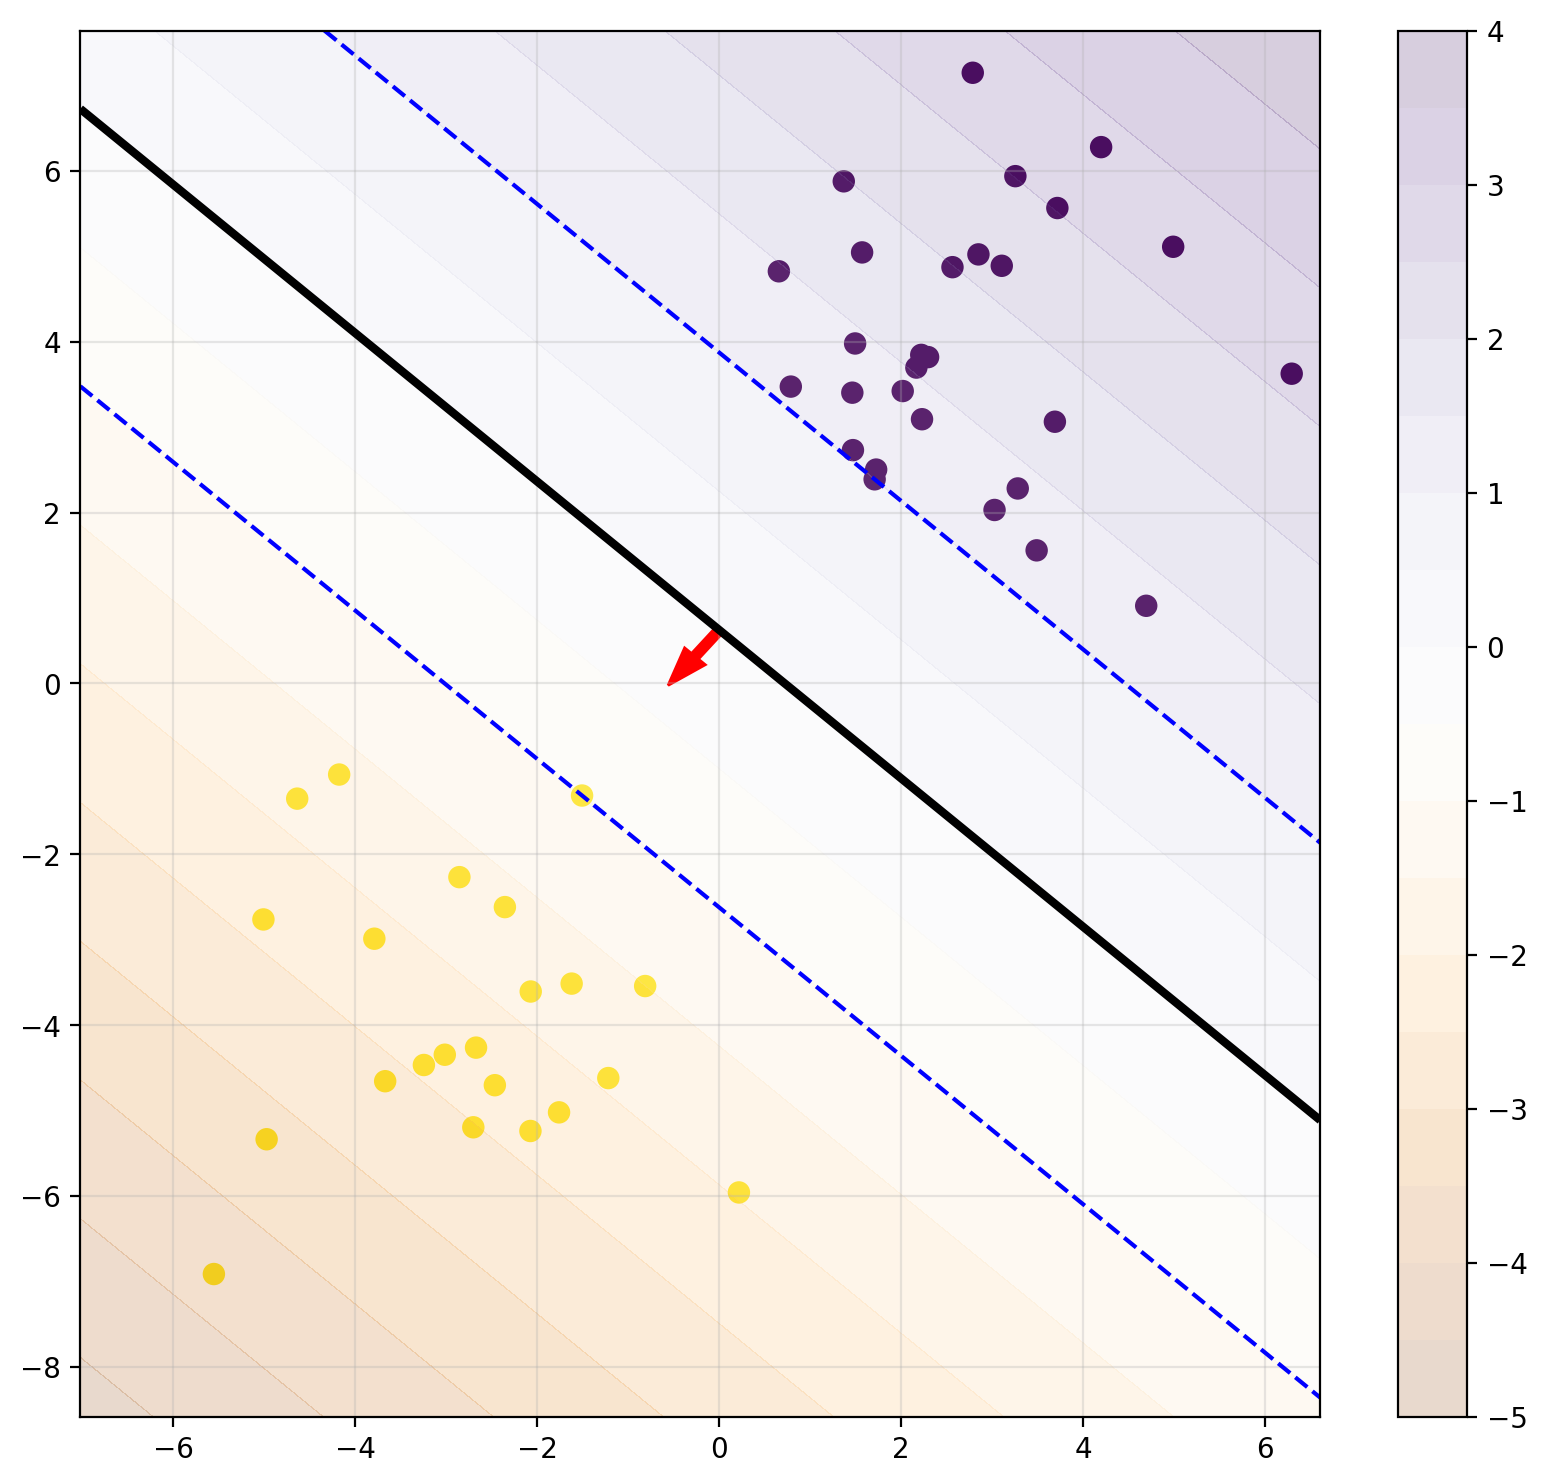

In [ ]:
ff,ax = plt.subplots(1,1,figsize=(10,9))
ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=50, cmap='viridis', label='training data')

YY = svc.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)

cs=ax.contourf(Xg, Yg, YY, 20, cmap='PuOr', alpha=0.2)
ax.contour(Xg, Yg, YY, [0], colors='black',linewidths=3)
ax.contour(Xg, Yg, YY, [-1,1], colors='blue', linestyles='--', linewidths=1.5)
bb = -b_svm/w_svm[1]
ax.arrow(0,bb,w_svm[0], w_svm[1],color='red', shape='full',width=.1)
_=ff.colorbar(cs, ax=ax)
ax.grid(alpha=0.3)


Now find out where the Support Vectors and the Lagrange Multipliers are stored in the class `SVC` objects. Write code that:
- stores the SVs in a variable called `Xsvs`
- store the labels corresponding to the SVs in  a variable called `Ysvs`

In [ ]:
# YOUR CODE
Xsvs = svc.support_vectors_
Ysvs = svc.dual_coef_[0]

Now run the following cell to plot the SVs

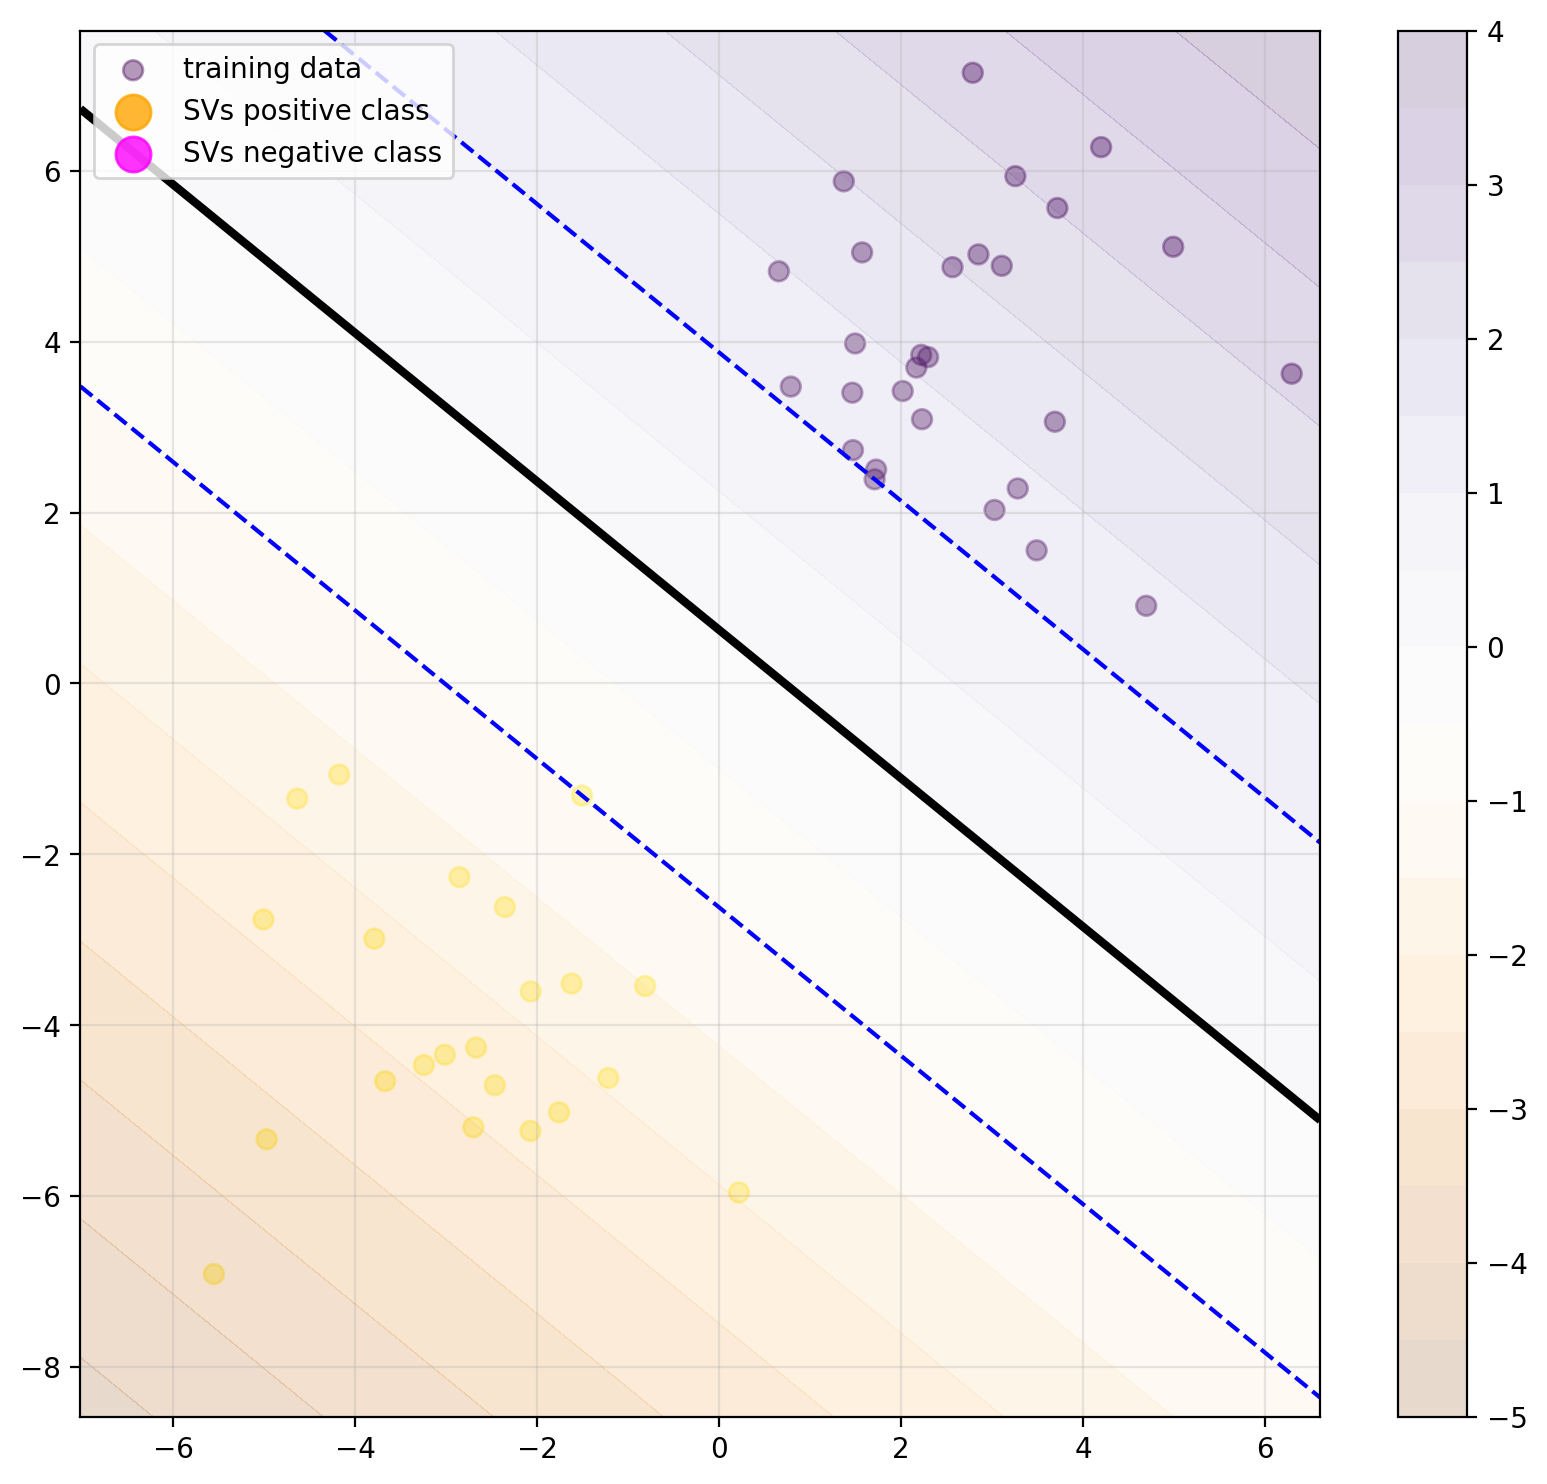

In [ ]:
ff,ax = plt.subplots(1,1,figsize=(10,9))
ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=50, cmap='viridis', label='training data', alpha=0.4)

YY = svc.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)

cs=ax.contourf(Xg, Yg, YY, 20, cmap='PuOr', alpha=0.2)
ax.contour(Xg, Yg, YY, [0], colors='black',linewidths=3)
ax.contour(Xg, Yg, YY, [-1,1], colors='blue', linestyles='--', linewidths=1.5)

_=ax.scatter(Xsvs[Ysvs==1, 0],
              Xsvs[Ysvs==1, 1],
              c='orange',
             marker = 'o',
              s=160,
              alpha=0.8,
              label='SVs positive class')
_=ax.scatter(Xsvs[Ysvs==-1, 0],
              Xsvs[Ysvs==-1, 1],
              c='magenta',
             marker = 'o',
              s=160,
              alpha=0.8,
              label='SVs negative class')

_=ff.colorbar(cs, ax=ax)
ax.grid(alpha=0.3)
ax.legend()


In the next cell write code that
- Instantiates an object of the SVC class, called `svc_svs`. With a linear kernel and $C=10^8$
- Fits the classifier with the support vectors found in the previous cell
- Compare the weight vector of this classifier with that of `svc`

In [ ]:

# YOUR CODE
svc_svs = SVC(kernel='linear', C=1e8)
#Fit the model using the support vectors and the predicted labels for the support vectors
svc_svs.fit(Xsvs, svc.predict(Xsvs))
print(svc_svs.coef_)
print(w_svm)

[[-0.26744803 -0.30787009]]
[-0.26744803 -0.30787009]


Now run the following cell to plot the clasifier obtained just with the SVs

NameError: name 'b_svs' is not defined

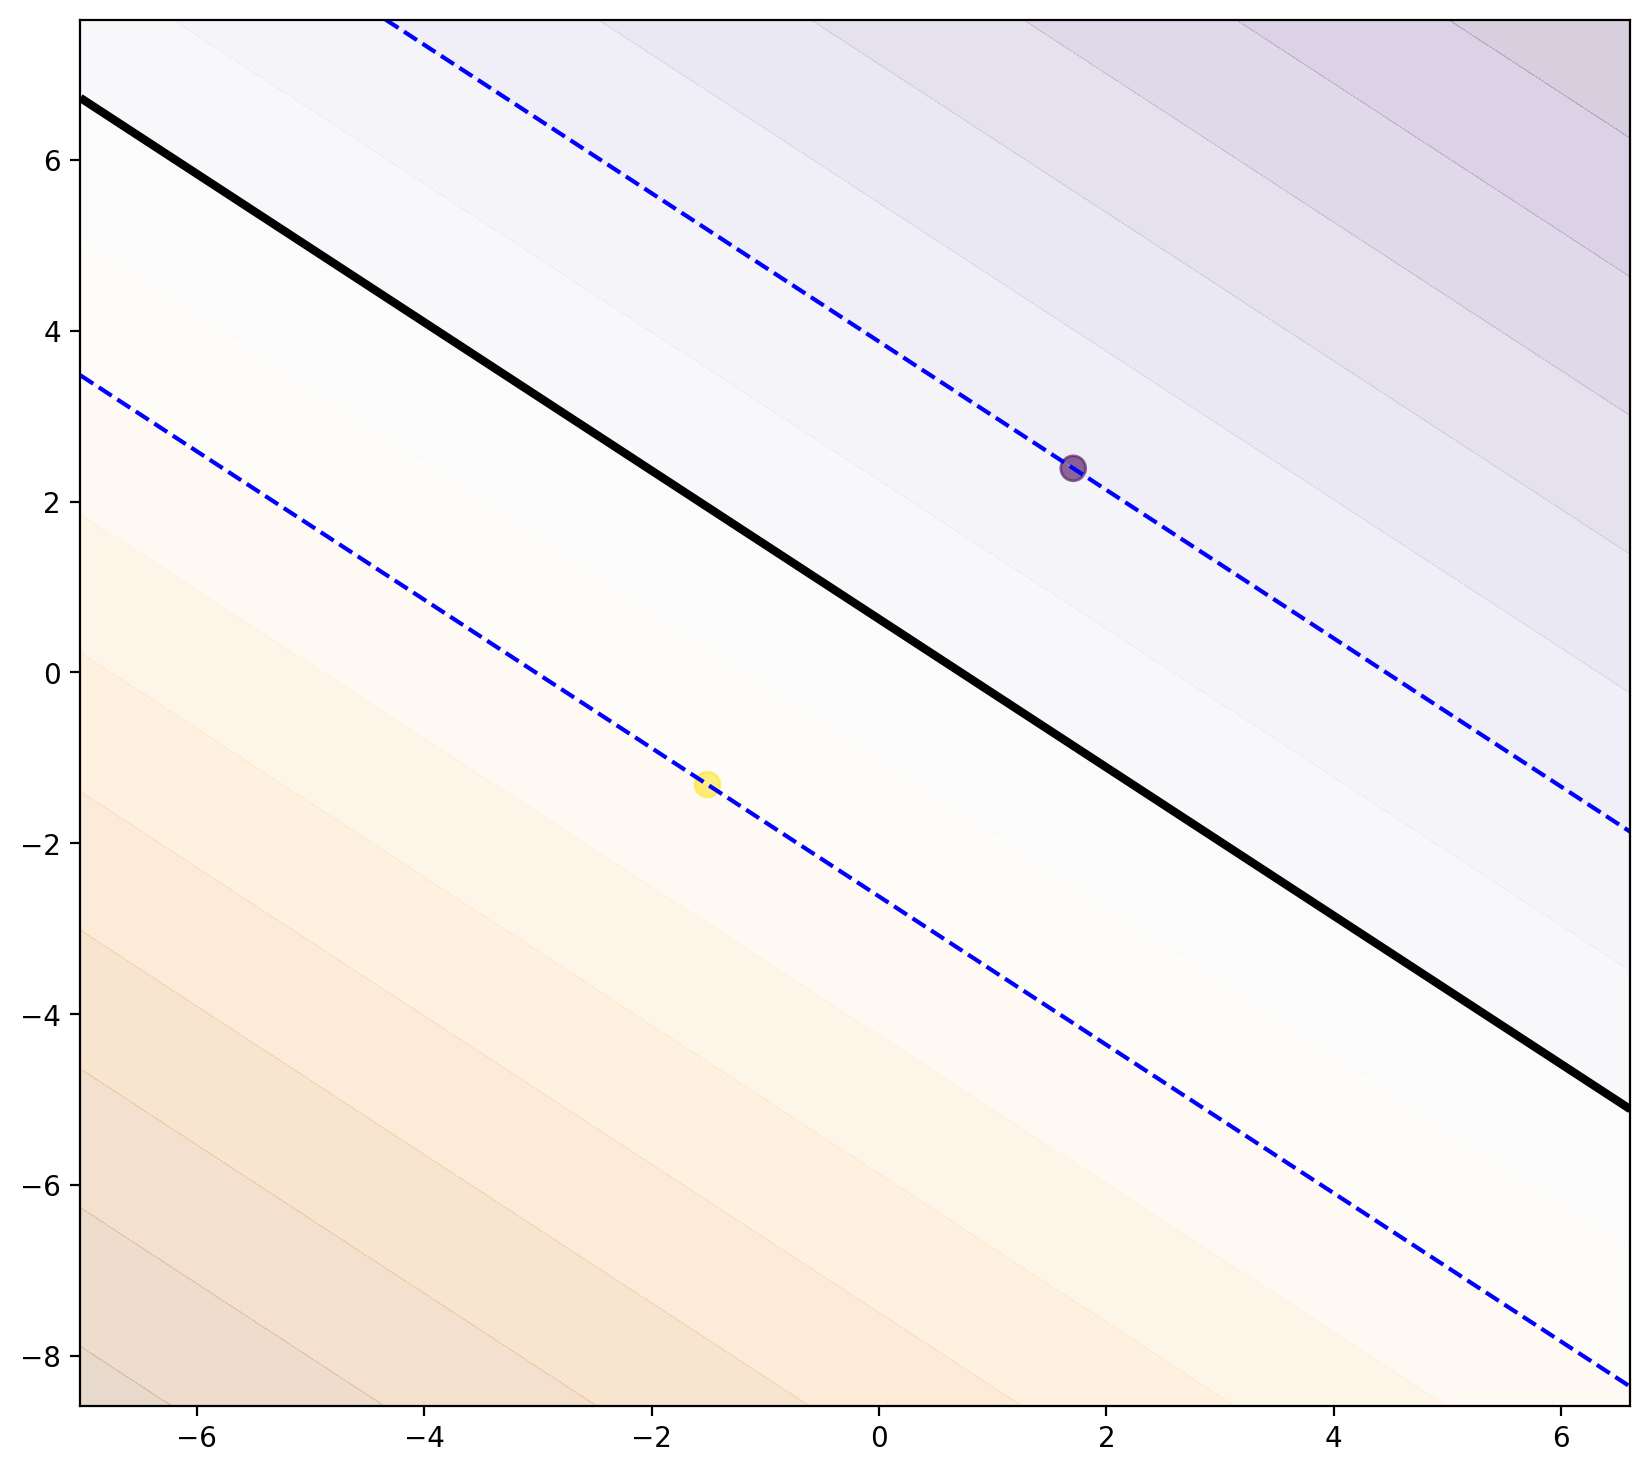

In [ ]:
ff,ax = plt.subplots(1,1,figsize=(10,9))
#ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=20, alpha=0.3, cmap='viridis', label='training data')
ax.scatter(Xsvs[:, 0], Xsvs[:, 1], c=Ysvs, s=80, alpha=0.7, cmap='viridis', label='SVs')
Yp = svc_svs.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)
cs=ax.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
ax.contour(Xg, Yg, Yp, [-1,1], colors='blue', linestyles='--', linewidths=1.5)
ax.arrow(0,-b_svs/w_svs[1],w_svs[0], w_svs[1],color='orange', shape='full',width=.1)
_=ff.colorbar(cs, ax=ax)
Yp = svc.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)
ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
ax.grid(alpha=0.3)


# 2. Linear SVM with soft margin

The outer loop in the code in the next cell proposes a binary classification task in which one of the observations moves towards the other class until the linear separability of the problem is violated.

The role of parameter $C$ in the SVM is precisely to control the trade-off between maximizing the margin and minimizing the number of margin violations (separability of the classes).

Array `v_C` in the next cell contains different values for parameter $C$ to qualitatively evaluate how can you control the margin. Explore different ranges of this parameter thata show this effect.

In the inner loop, write code that:
- instantiates a SVC with linear kernel and the corresponding value for parameter $C$
- fits the SVC with `Xtrain1` and `Ytrain1`


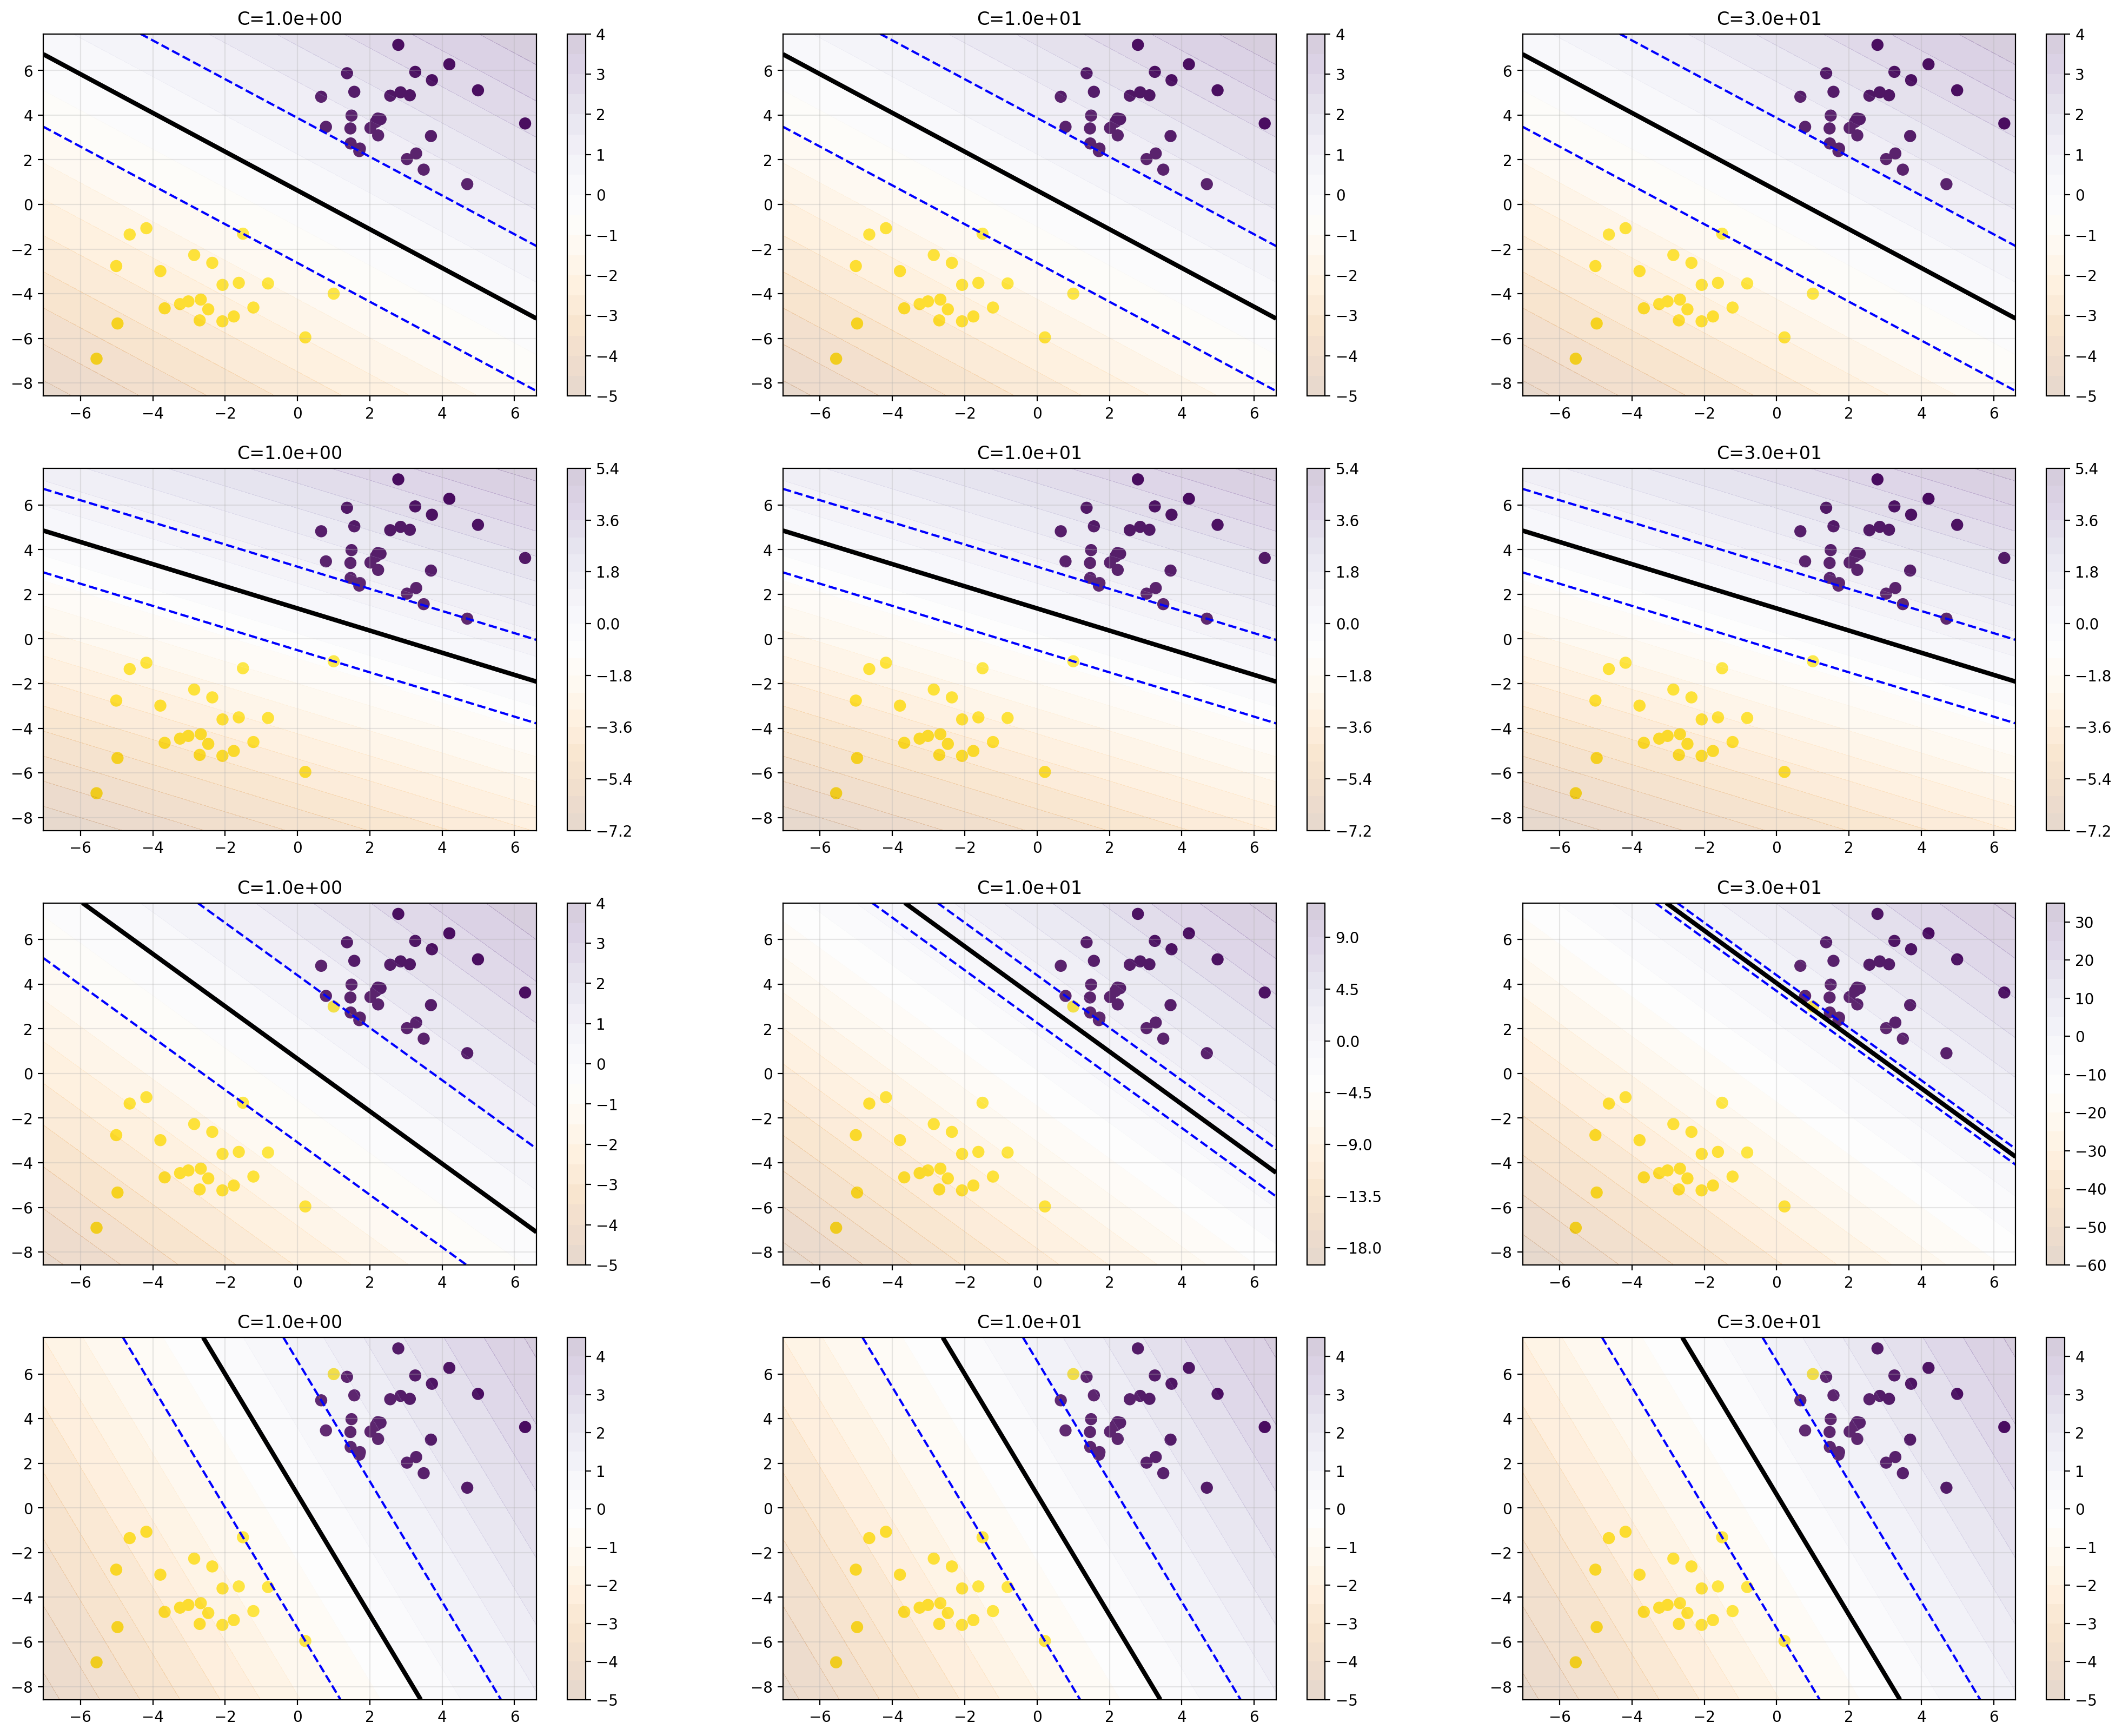

In [ ]:
v_z = np.array([-4, -1, 3, 6]) # controls the separability of the problem

v_C = np.array([1,10,30]) # write your range

nrows = len(v_z)
ncols = len(v_C)

ff, aa = plt.subplots(nrows, ncols, figsize=(25,20))

for rr in range(nrows):
    delta_z = v_z[rr]
    Xtrain1 = np.vstack((Xtrain, np.array([1, delta_z]).reshape(1,-1)))
    Ytrain1 = np.hstack((Ytrain, np.ones(1)))
    for cc in range(ncols):

        # YOUR CODE
        C = v_C[cc]
        svc = SVC(kernel='linear', C=C)
        svc.fit(Xtrain1, Ytrain1)

        ax = aa[rr][cc]
        ax.scatter(Xtrain1[:, 0], Xtrain1[:, 1], c=Ytrain1, s=50, cmap='viridis', label='training data')
        Yp = svc.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)
        cs=ax.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
        ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
        ax.contour(Xg, Yg, Yp, [-1,1], colors='blue', linestyles='--', linewidths=1.5)
        _=ff.colorbar(cs, ax=ax)
        ax.grid(alpha=0.3)
        ax.set_title('C={0:.1e}'.format(C))

# 3. Non-linear SVM

Run the next cell to generate a new toy data set.

In [ ]:
X, Y = datasets.make_moons(noise=0.3,
                           random_state=0,
                           n_samples=200)
Y[Y==0]=-1


Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=50)

x_grid, Xshape, Xg, Yg = dame_grid(X, nn=20)



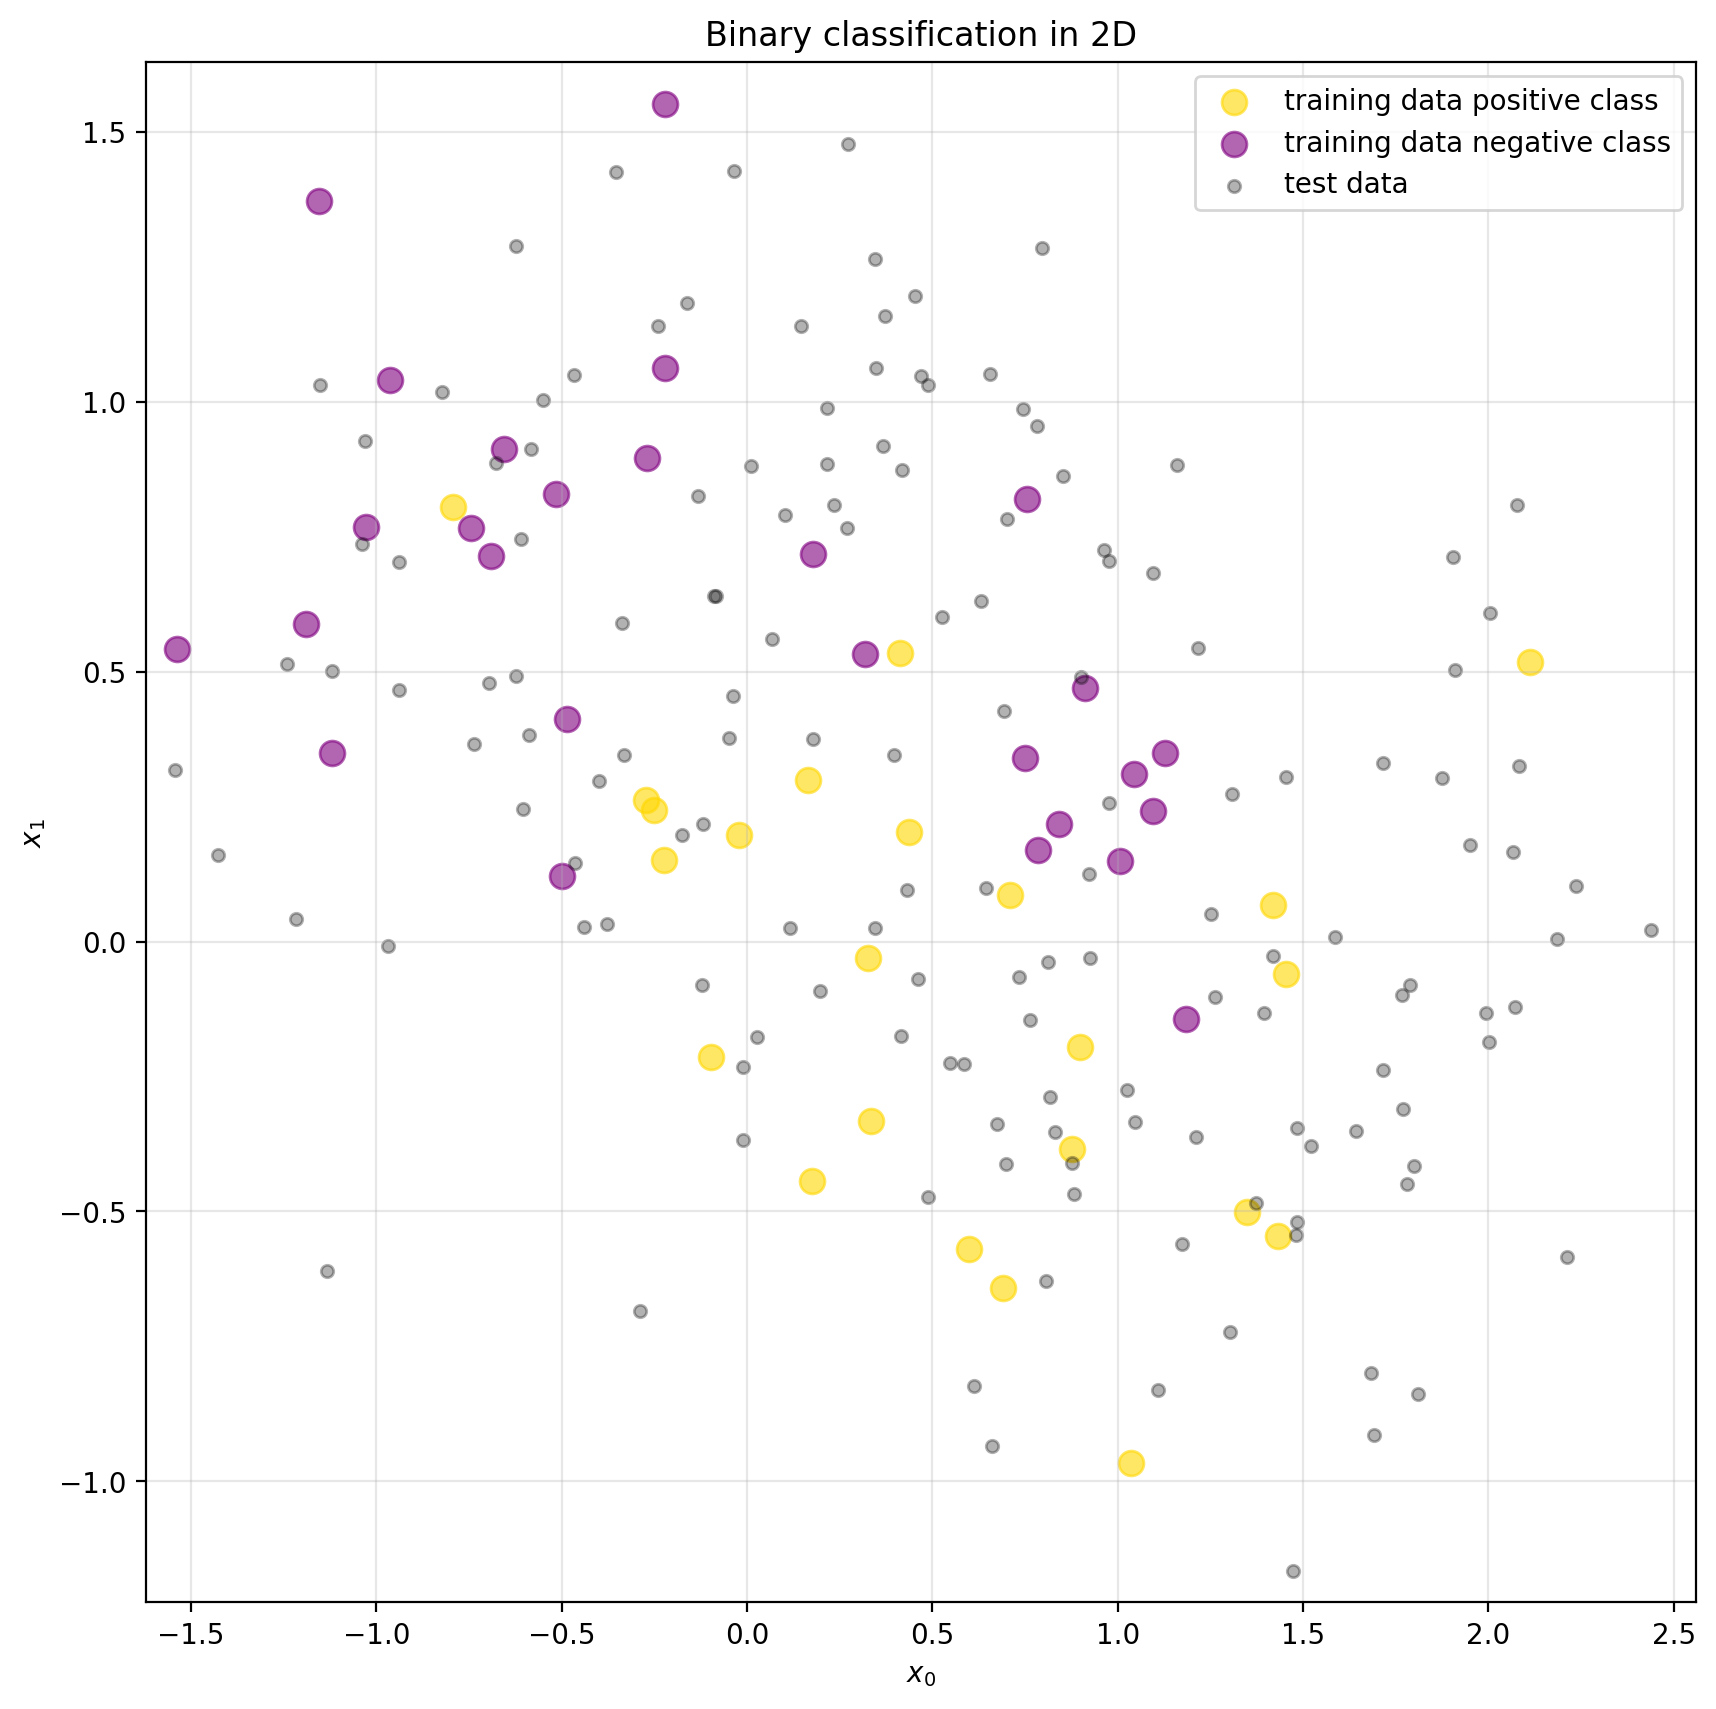

In [ ]:
plt.figure(figsize=(10,10))


_=plt.scatter(Xtrain[Ytrain==1, 0],
              Xtrain[Ytrain==1, 1],
              c='gold',
              s=80,
              alpha=0.6,
              label='training data positive class')
_=plt.scatter(Xtrain[Ytrain==-1, 0],
              Xtrain[Ytrain==-1, 1],
              c='purple',
              s=80,
              alpha=0.6,
              label='training data negative class')

_=plt.scatter(Xtest[:, 0], Xtest[:, 1], s=20, color='black', alpha=0.3, label='test data')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Binary classification in 2D')
plt.axis([np.min(x_grid[:,0]),
          np.max(x_grid[:,0]),
          np.min(x_grid[:,1]),
          np.max(x_grid[:,1])])
_=plt.legend()
_=plt.grid(alpha=0.3)

## 3.1 Try a hard margin solution

Our first attempt will be to find a kernel able to give a solution with zero margin violations in the training set. For this purpose we will explore different values of the parameter $\gamma$ of a RBF kernel until we achieve zero errors in the training set.

Remember to use a value of $C$ high enough. And to name `svc_hard_m` the classifier

In [ ]:
# YOUR CODE
gamma = 0.01
for i in np.linspace(0,1000,1):
  gamma = gamma *2
  svc_hard_m = SVC(kernel='rbf', C=1e8, gamma=gamma).fit(Xtrain, Ytrain)
  min_margin = np.min(np.absolute( svc_hard_m.decision_function(Xtrain)))
  if min_margin >= 1e-3:
    break

print(min_margin)
print(gamma)

0.043690254319699307
0.02


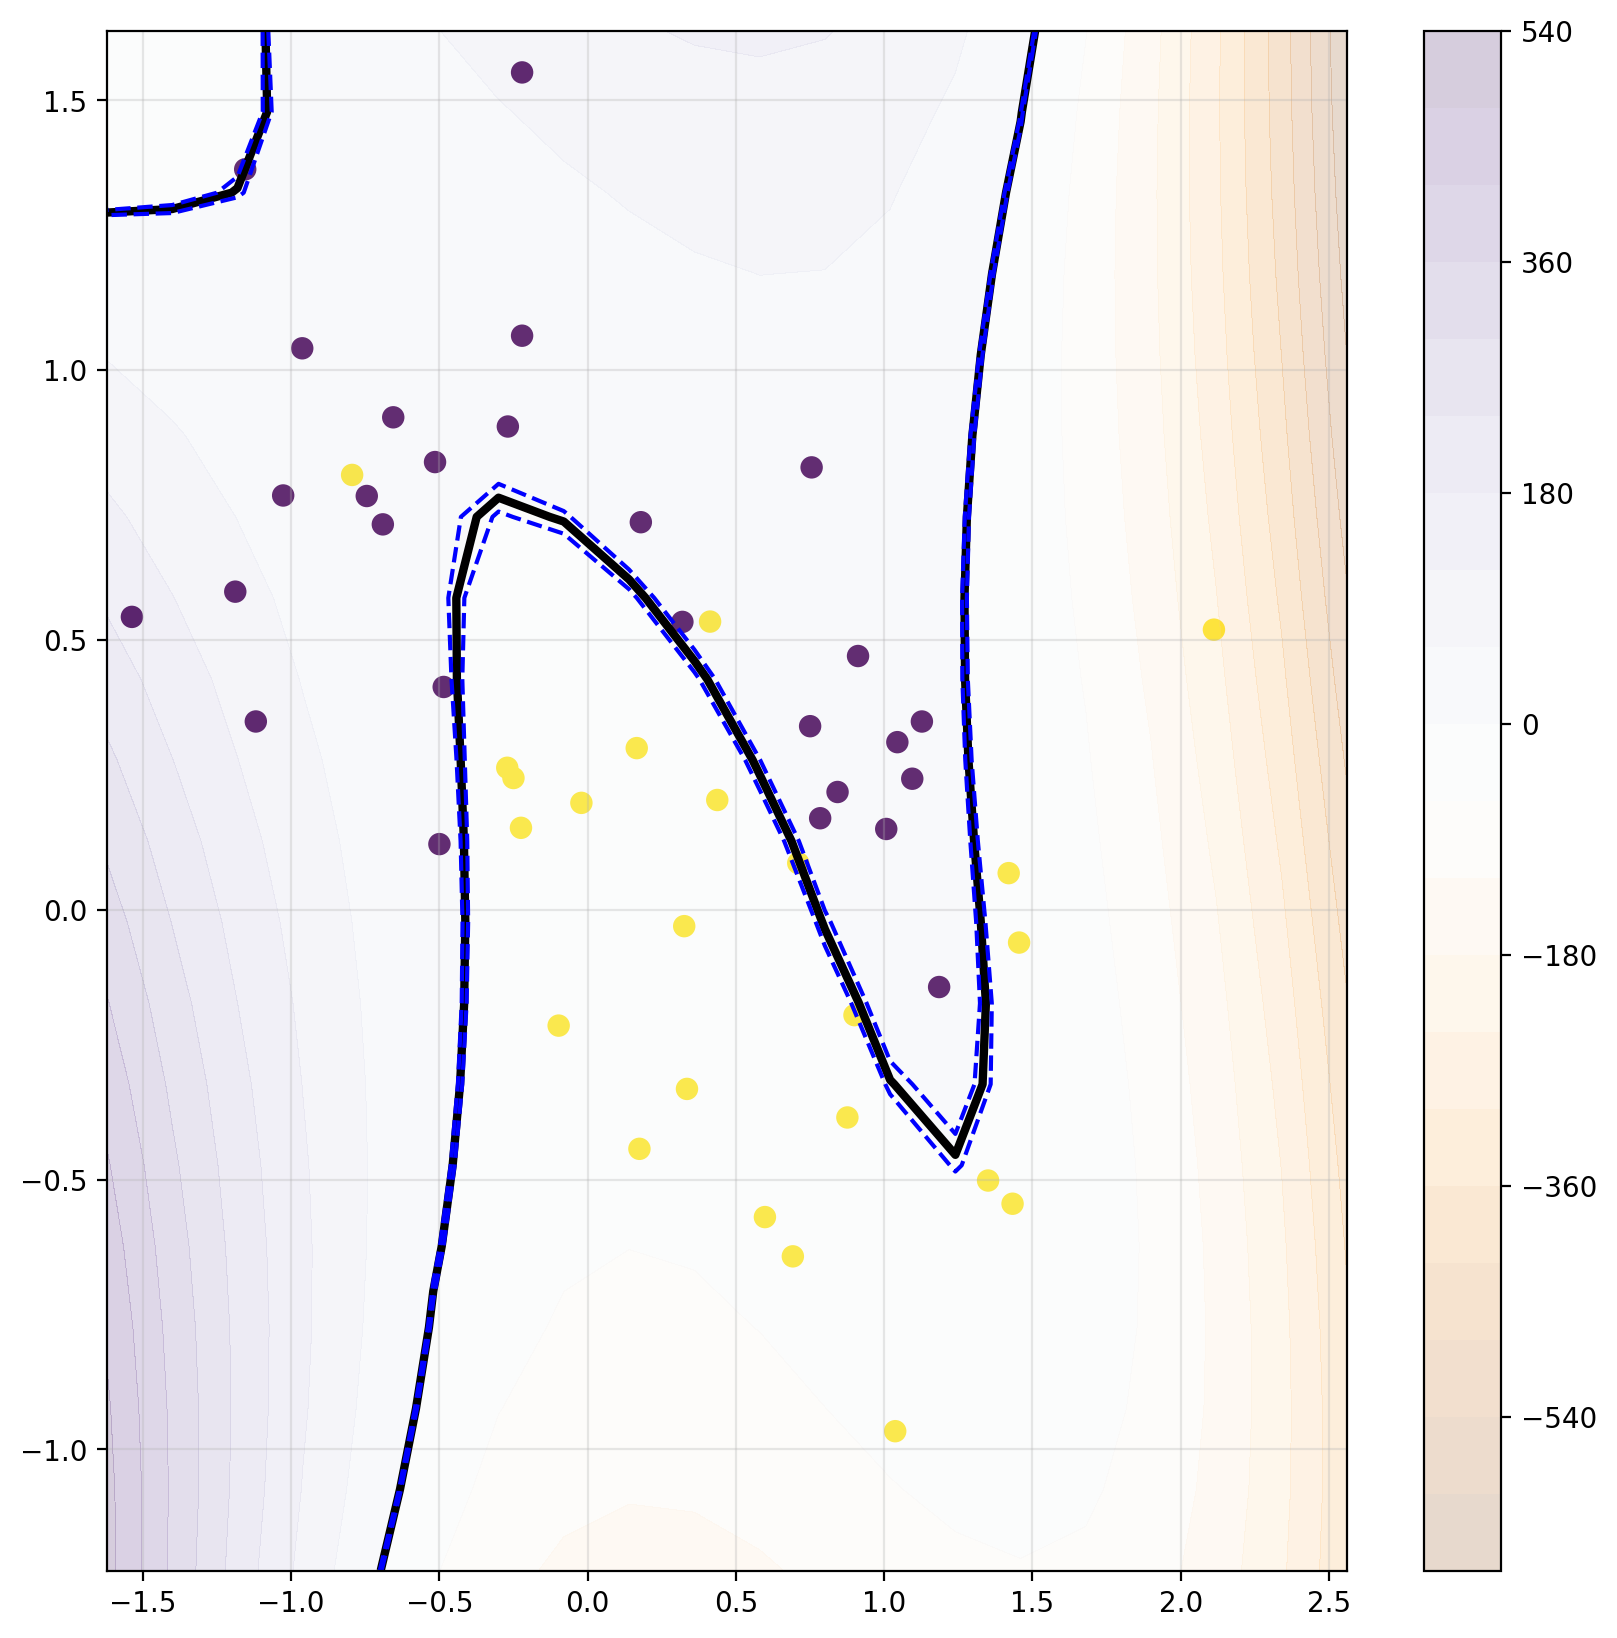

In [ ]:
ff, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=50, cmap='viridis', label='training data')
Yp = svc_hard_m.classes_[0]*svc_hard_m.decision_function(x_grid).reshape(Xshape)
cs=ax.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
ax.contour(Xg, Yg, Yp, [-1,1], colors='blue', linestyles='--', linewidths=1.5)
_=ff.colorbar(cs, ax=ax)
ax.grid(alpha=0.3)

Now print the accuracy in the test set of this classifier.

In [ ]:
# YOUR CODE
print(svc_hard_m.score(Xtest, Ytest))

0.8933333333333333


Run the next cell to plot the test set and the classifier

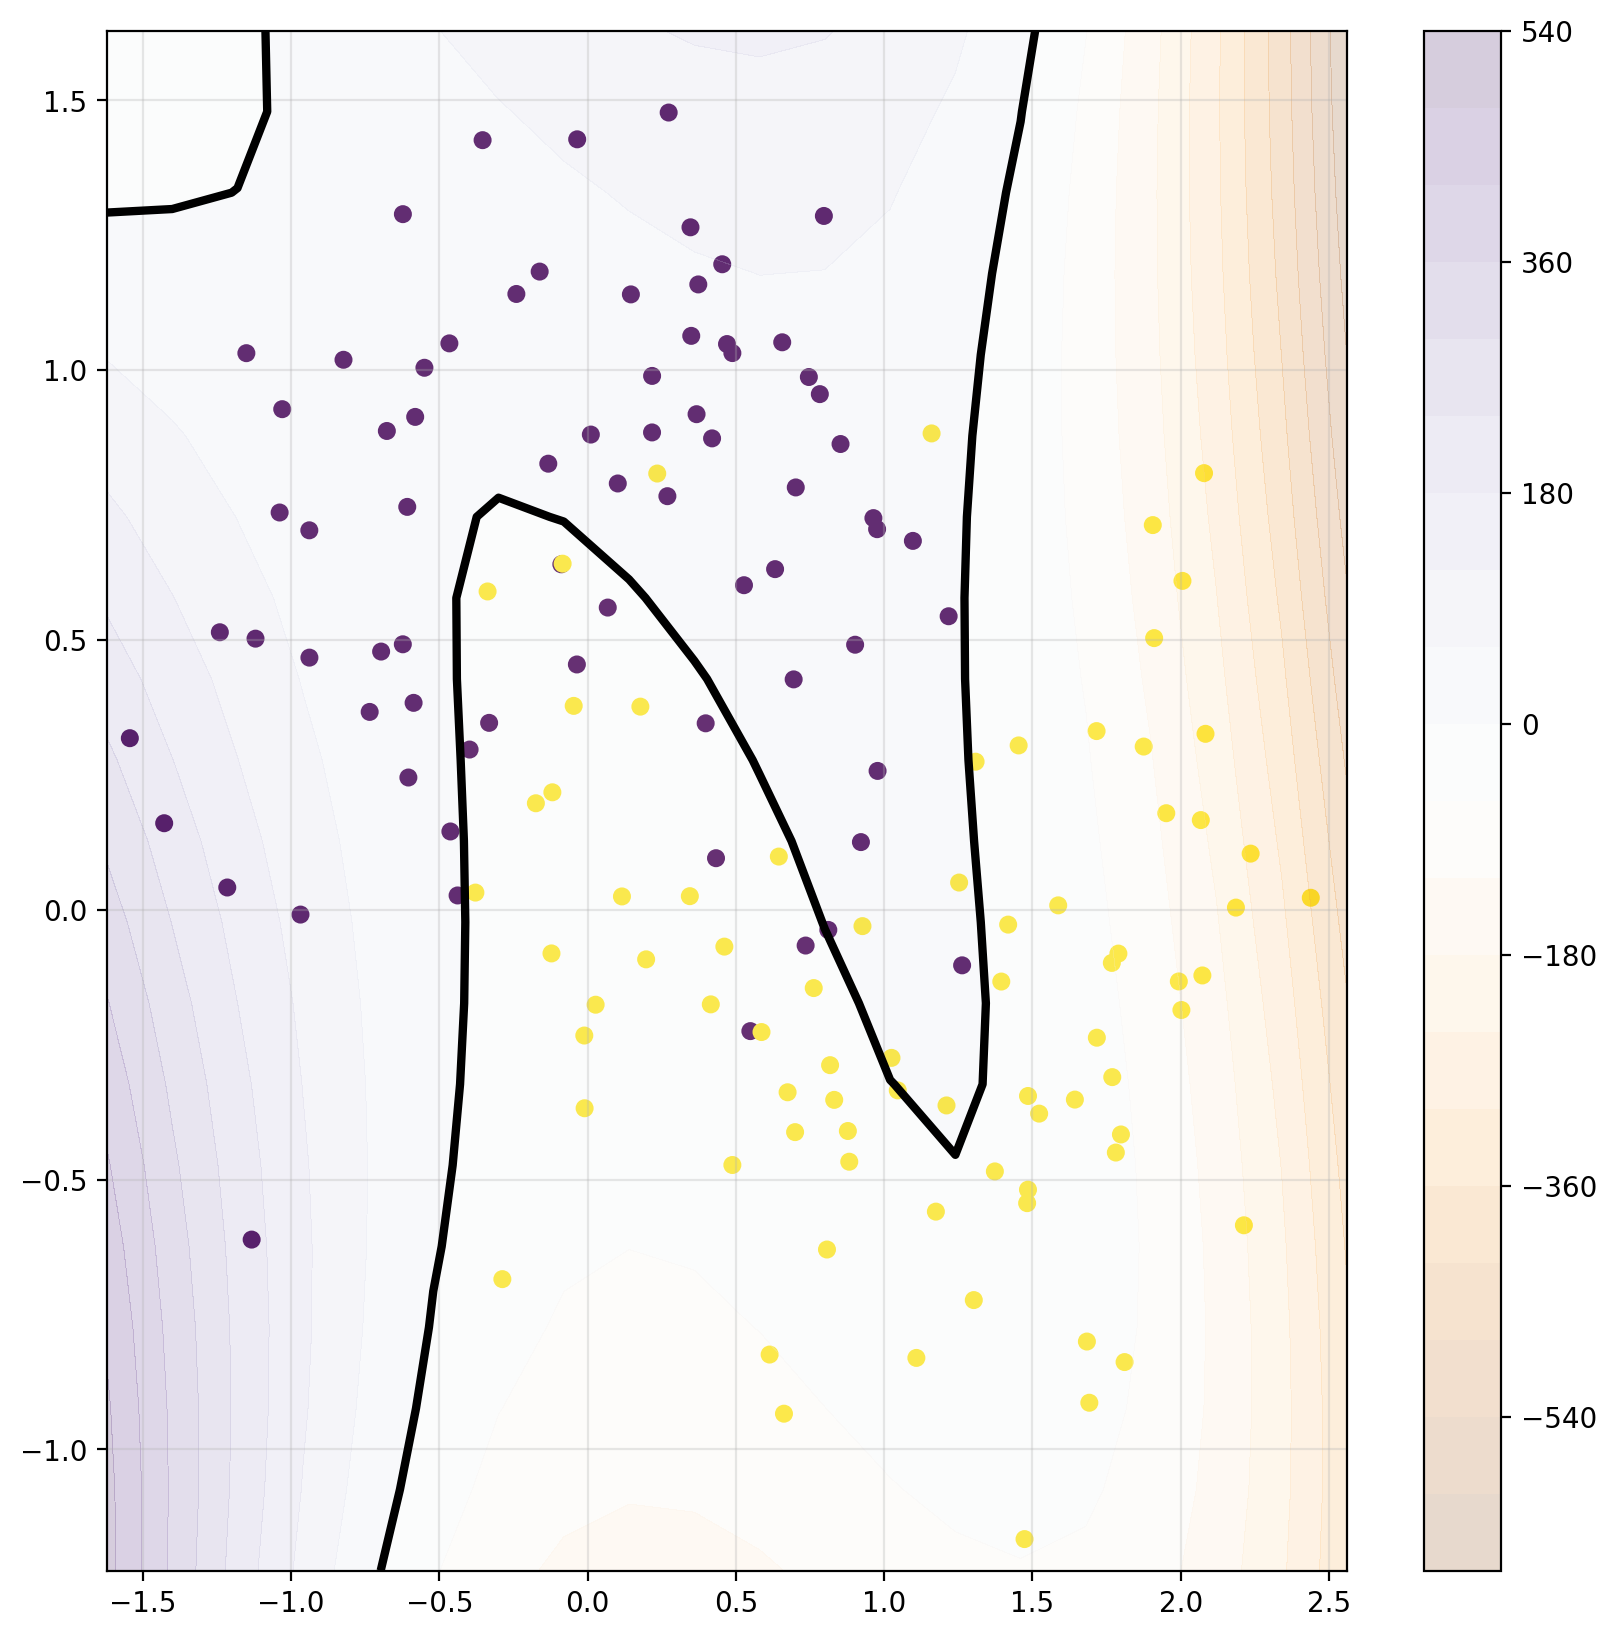

In [ ]:
ff, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(Xtest[:, 0], Xtest[:, 1], c=Ytest, s=30, cmap='viridis', label='test data')
Yp = svc_hard_m.classes_[0]*svc_hard_m.decision_function(x_grid).reshape(Xshape)
cs=ax.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
_=ff.colorbar(cs, ax=ax)
ax.grid(alpha=0.3)

## 3.2 soft margin and RBF kernel

In the final section we will look for smoother classifiers by exploring combinations of $C$ and $\gamma$.

In the next cell write code that fits a SVM with RBF kernel and the corresponding values for parameters `C` and `gamma` (given by the iterations of the nested for loops). Also evaluate the classifier in the test set and store the accuracy in a variable called `acc_test`; the accuracy in the training set should be stored in a variable called `acc_train`.

And explore ranges for $C$ and $\gamma$ that achieve qualitatively different situations of smoothness and accuracy

In [ ]:
v_C = np.array([1e3,2e4,3e5,1e6,1e6,1e7]) # your range
v_gamma = np.array([0.1,1,2,3.5,10,50,100]) # your range
nrows = len(v_gamma)
ncols = len(v_C)

ff, aa = plt.subplots(nrows, ncols, figsize=(25,20))

for rr in range(nrows):
    gamma = v_gamma[rr]

    for cc in range(ncols):

        # YOUR CODE
        C = v_C[cc]
        svc = SVC(kernel='rbf', C=C, gamma=gamma)
        svc.fit(Xtrain, Ytrain)

        acc_test = svc.score(Xtest, Ytest)
        acc_train = svc.score(Xtrain, Ytrain)
        ax = aa[rr][cc]
        ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain, s=50, cmap='viridis', label='training data')
        Yp = svc.classes_[0]*svc.decision_function(x_grid).reshape(Xshape)
        cs=ax.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
        ax.contour(Xg, Yg, Yp, [0], colors='black',linewidths=3)
        ax.contour(Xg, Yg, Yp, [-1,1], colors='blue', linestyles='--', linewidths=1.5)
        _=ff.colorbar(cs, ax=ax)
        ax.grid(alpha=0.3)
        ax.set_title('test={0:.2f}, train={1:.2f}'.format(acc_test, acc_train))

Output hidden; open in https://colab.research.google.com to view.